In [1]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier


class Classifiers(object):

    def __init__(self,train_data,train_labels,name,hyperTune=True):
        self.train_data=train_data
        self.train_labels=train_labels
        self.model_name=name
        self.set_model_name()
        #self.construct_all_models(hyperTune)
        self.accuracy = ""
        self.info_train = ""
        self.test_core = ""

    def return_info(self):
        return self.info_train
    
    def return_accuracy(self):
        return self.accuracy
    
    def return_test_core(self):
        return self.test_core
    
    def set_model_name(self):
        model = ""
        if self.model_name == "Suport Vector Machine":
            model = "SVM"
    
        elif  self.model_name == "Logistic Regression":
            model = "LogisticRegression"
            
        elif  self.model_name == "KNeighbors Classifier":
            model = "KNN"
            
        elif self.model_name == "Random Forest Classifier":
            model = "RandomForestClassifier"
            
        self.model_name = model
        
        
    def store_model(self, model, model_name = ""):
        # NOTE: sklearn.joblib faster than pickle of Python
        # INFO: can store only ONE object in a file
        if model_name == "": 
            model_name = type(model).__name__
        joblib.dump(model,'models/' + model_name + '_model.pkl')
    
    def construct_all_models(self,hyperTune):
        if hyperTune:
            #3 models KNN SCM and LR
            self.models={'SVM':[SVC(kernel='linear',probability=True),dict(C=np.arange(0.01, 2.01, 0.2))],\
                         'LogisticRegression':[lr(),dict(C=np.arange(0.1,3,0.1))],\
                         'KNN':[KNeighborsClassifier(),dict(n_neighbors=range(1, 100))],\
                         'RandomForestClassifier': [RandomForestClassifier(n_estimators=100), dict(min_samples_leaf=np.arange(2, 20, 1))]}
            for name,candidate_hyperParam in self.models.items():
                #update each classifier after training and tuning
                if name == self.model_name:
             
                    self.models[name] = self.train_with_hyperParamTuning(candidate_hyperParam[0],name,candidate_hyperParam[1])
                   
            print ('\nTraining process finished\n\n\n')
            
        return self.accuracy, self.test_core, self.info_train

    def train_with_hyperParamTuning(self,model,name,param_grid):
        #grid search method for hyper-parameter tuning
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
        grid.fit(self.train_data, self.train_labels)
        joblib.dump(grid,'saved_objects/' + name  + '_gridsearch.pkl')
        self.store_model(grid, name)
        
        self.info_train = '\nThe best hyper-parameter for -- {} is {}, the corresponding mean accuracy through 10 Fold test is {} \n'\
            .format(name, grid.best_params_, grid.best_score_)
        print(self.info_train)

        model = grid.best_estimator_
        train_pred = model.predict(self.train_data)
        self.accuracy = '{} train accuracy = {}\n'.format(name,(train_pred == self.train_labels).mean())
        print(self.accuracy)
        
       
        return model

    def prediction_metrics(self,test_data,test_labels,name):

        #accuracy
        self.test_core = '{} test accuracy = {}\n'.format(self.model_name,(self.models[self.model_name].predict(test_data) == test_labels).mean())
        print(self.test_core)

        #AUC of ROC
        prob = self.models[self.model_name].predict_proba(test_data)
        auc=roc_auc_score(test_labels,prob[:,1])
        print('Classifier {} area under curve of ROC is {}\n'.format(self.model_name,auc))

        #ROC
        fpr, tpr, thresholds = roc_curve(test_labels, prob[:,1], pos_label=1)
        #self.roc_plot(fpr,tpr,name,auc)
        return self.test_core

    def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}\nPlease close it to continue'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()

In [2]:
import pandas as pd
raw_data = pd.read_csv('trainning_data.csv')

In [3]:
#"label", "phone", "student name", "id", "date", "ip", "model"
import pandas as pd
raw_data = pd.read_csv('exam_data.csv')
select_columns = raw_data[["label", "id", "student name", "ip", "phone", "date", "model"]]
select_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         40 non-null     object
 1   id            40 non-null     object
 2   student name  40 non-null     object
 3   ip            40 non-null     object
 4   phone         26 non-null     object
 5   date          40 non-null     object
 6   model         23 non-null     object
dtypes: object(7)
memory usage: 2.3+ KB


In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data, test_size=0.30, random_state=42) # set random_state to get the same training set all the time, 

train_set_labels = train_set["label"].copy()
train_set = train_set.drop(columns = "label") 
test_set_labels = test_set["label"].copy()
test_set = test_set.drop(columns = "label") 

In [8]:
classifiers = Classifiers(train_set,train_set_labels, "Random Forest Classifier")

In [9]:
accuracy, test_core, info_train = classifiers.construct_all_models(hyperTune=True)



The best hyper-parameter for -- RandomForestClassifier is {'min_samples_leaf': 3}, the corresponding mean accuracy through 10 Fold test is 0.8874999999999998 

RandomForestClassifier train accuracy = 1.0


Training process finished





In [ ]:
for name,candidate_hyperParam in classifiers.models.items():
  print(candidate_hyperParam)

KNN test accuracy = 0.6923076923076923

Classifier KNN area under curve of ROC is 0.7662721893491125



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


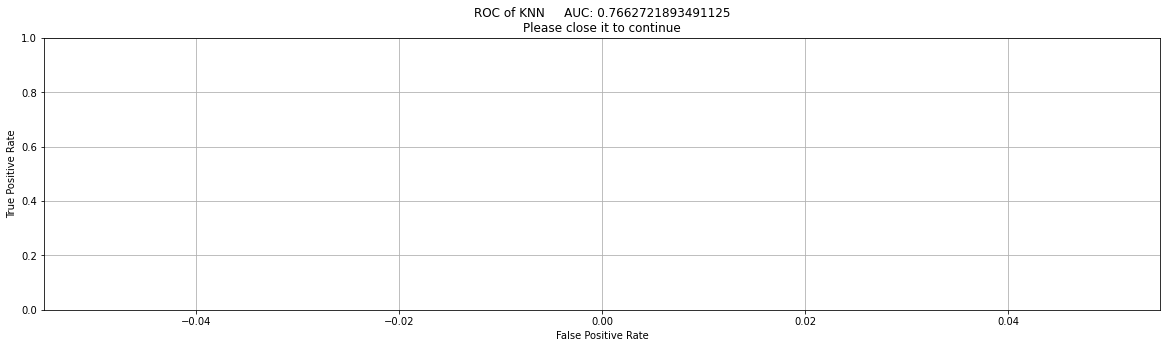

In [37]:
classifiers.prediction_metrics(test_set, test_set_labels, 'KNN')

LogisticRegression test accuracy = 0.7307692307692307

Classifier LogisticRegression area under curve of ROC is 0.7174556213017752



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


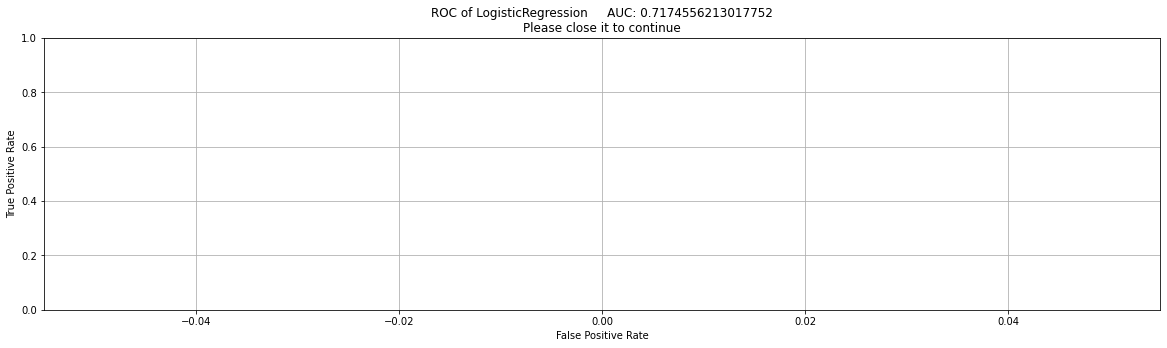

In [38]:
classifiers.prediction_metrics(test_set, test_set_labels, 'LogisticRegression')

SVM test accuracy = 0.7307692307692307

Classifier SVM area under curve of ROC is 0.7381656804733727



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


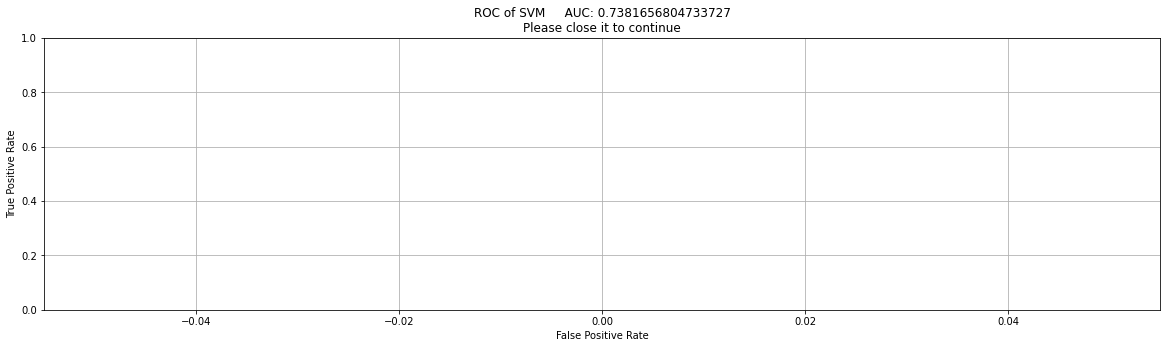

In [39]:
classifiers.prediction_metrics(test_set, test_set_labels, 'SVM')

In [11]:
name = 'LogisticRegression'
print('{} test accuracy = {}\n'.format(name,(classifiers.models[name].predict(test_set) == test_set_labels).mean()))
prob = classifiers.models[name].predict_proba(test_set)


LogisticRegression test accuracy = 0.6666666666666666



In [ ]:
auc = roc_auc_score(test_set_labels, prob[:,1])
print('Classifier {} area under curve of ROC is {}\n'.format(name,auc))

fpr, tpr, thresholds = roc_curve(test_set_labels, prob[:,1], pos_label=1)

In [ ]:
def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}\nPlease close it to continue'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()

In [ ]:
classifiers.roc_plot(fpr, tpr, name, auc)